In [17]:

import numpy as np
import astropy.units as u
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload
from astropy.io import fits
import copy
import time
from datetime import timezone 

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize, CenteredNorm
from matplotlib.patches import Circle, Rectangle
from matplotlib.gridspec import GridSpec

import esc_llowfsc_sim
from esc_llowfsc_sim.math_module import xp, xcipy, ensure_np_array
from esc_llowfsc_sim import utils, detector, dm, wfe, source_flux, shmim_utils
import esc_llowfsc_sim.esc_fraunhofer as esc

from magpyx.utils import ImageStream

import cupy as cp
cp.cuda.Device(6).use()

model_params = utils.load_pickle(esc_llowfsc_sim.path/'data/example_fraunhofer_params_1K.pkl')
wfe_data = utils.load_pickle(esc_llowfsc_sim.path/'data/example_wfe_data_1K.pkl')

Total flux over bandpass = 2.482e+09 ph / (s m2)


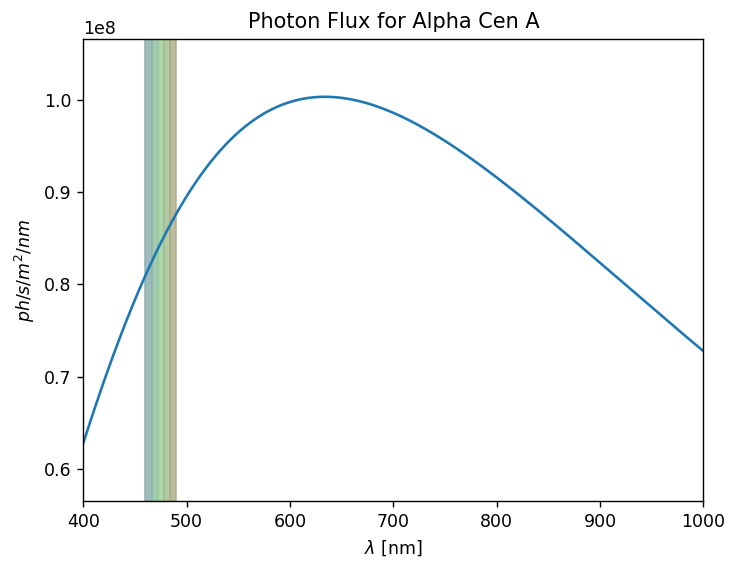

In [18]:
Nwaves = 5
bw = 0.05
waves = np.linspace(model_params['wavelength_c']*(1 - bw/2), model_params['wavelength_c']*(1 + bw/2), Nwaves)

mag_alphaCenA = 0
name = 'Alpha Cen A'
distance = 4.344*u.lightyear
radius = 1.2175*u.R_sun
temp = 5790*u.Kelvin

source = source_flux.SOURCE(waves, distance, temp, diameter=2*radius, name=name)
source.plot_spectrum_ph()
flux_per_wave = source.calc_fluxes()
total_ep_flux = np.sum(flux_per_wave)
print(f'Total flux over bandpass = {total_ep_flux:.3e}')

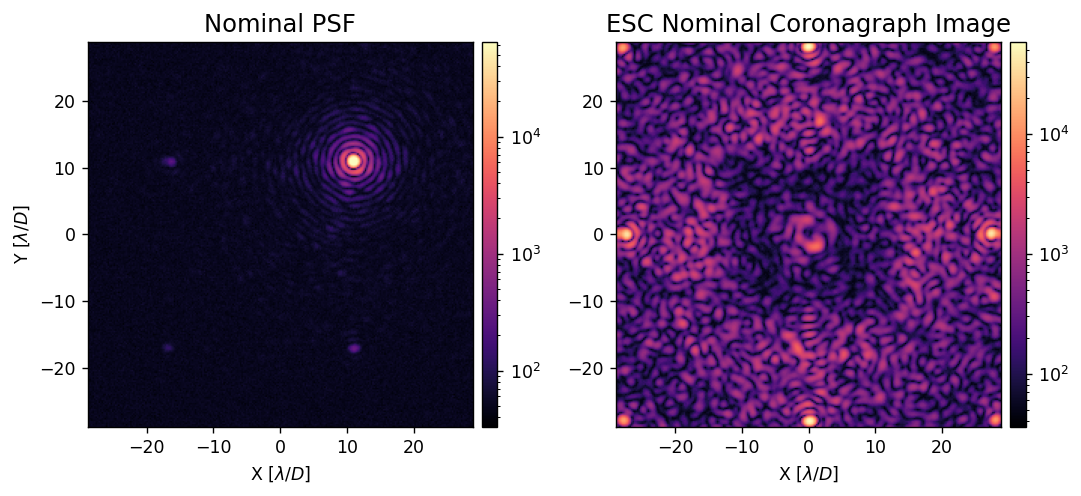

In [19]:
reload(esc)
reload(utils)

M = esc.single(
    **model_params,
    **wfe_data,
    entrance_flux=total_ep_flux,
)

M.CAMSCI = detector.IMXDETECTOR(
    exp_time=0.005, 
    throughput=0.06, 
    qe=0.75, 
    gain=0, 
    blacklevel=50, 
    dark_current=0.0025, 
    bits=16,
)

M.use_vortex = 1
M.add_fsm([0, 50, 50])
M.CAMSCI.exp_time = 0.005
psf = M.snap_camsci()

M.zero_fsm()
M.CAMSCI.exp_time = 1.0
coro_im = M.snap_camsci()

utils.imshow(
    [psf, coro_im],
    titles=[f'Nominal PSF', 
            f'ESC Nominal Coronagraph Image'],
    title_fzs=[14]*4,
    xlabels=['X [$\lambda/D$]']*4,
    ylabels=['Y [$\lambda/D$]', None]*2,
    pxscls=3*[M.camsci_pxscl_lamDc],
    norms=[LogNorm(), LogNorm(),  LogNorm(), LogNorm()], 
    # Nrows=2, Ncols=2, 
    # wspace=0.3,
)
    



# Test a live process that reads and writes to SHMIMS so we can get live views of the simulated camera images.

In [14]:
# shmim_utils.create_shmim('camscisim', (M.ncamsci, M.ncamsci))
# shmim_utils.create_shmim('opdsim', (10, 1))
# shmim_utils.create_shmim('fsm01', (3, 1))
# shmim_utils.create_shmim('fsm02', (3, 1))
# shmim_utils.create_shmim('ncamsci', (1,1))
# shmim_utils.create_shmim('camscishutter', (1,1))
# shmim_utils.create_shmim('camsciexptime', (1,1))
# shmim_utils.create_shmim('camscigain', (1,1))
# shmim_utils.create_shmim('vmag', (1,1))

CAMSCI_STREAM = ImageStream('camscisim')
CAMSCI_SHUTTER_STREAM = ImageStream('camscishutter')
CAMSCI_EXPTIME_STREAM = ImageStream('camsciexptime')
CAMSCI_GAIN_STREAM = ImageStream('camscigain')
VMAG_STREAM = ImageStream('vmag')
OPD_STREAM = ImageStream('opdsim')
FSM1_STREAM = ImageStream('fsm01')
FSM2_STREAM = ImageStream('fsm02')
DMT_STREAM = ImageStream('dm00disp')
DM0_STREAM = ImageStream('dm00disp00')

CAMSCI_EXPTIME_STREAM.write(np.array([[M.CAMSCI.exp_time]]))
DM0_STREAM.write(ensure_np_array(wfe_data['dm_ref']*1e6))

In [24]:
CAMSCI_SHUTTER_STREAM.grab_latest()[0,0] < 0.5

np.True_

In [15]:

wfe_modes = utils.create_zernike_modes(M.APERTURE, nmodes=10, remove_modes=1)

def snap_camsci_live():
    wfe_coeff = OPD_STREAM.grab_latest()[0]

    fsm_command_1 = FSM1_STREAM.grab_latest()[0]
    fsm_command_2 = FSM2_STREAM.grab_latest()[0]

    dm_command = DMT_STREAM.grab_latest() / 1e6

    new_wfe = xp.sum( xp.array(wfe_coeff[:, None, None]) * wfe_modes, axis=0)

    vmag = VMAG_STREAM.grab_latest()[0,0]
    M.flux_scale_factor = 2.512**(mag_alphaCenA - vmag)
    M.camsci_shutter = CAMSCI_SHUTTER_STREAM.grab_latest()[0,0]>0.5
    M.CAMSCI.exp_time = CAMSCI_EXPTIME_STREAM.grab_latest()[0,0]
    M.CAMSCI.gain = CAMSCI_GAIN_STREAM.grab_latest()[0,0]
    M.set_prefpm_wfe(wfe_data['PREFPM_OPD'] + new_wfe)
    M.set_fsm(xp.array(fsm_command_1 + fsm_command_2))
    M.set_dm(xp.array(dm_command), channel=0)

    camsci_im = M.snap_camsci()
    
    CAMSCI_STREAM.write(ensure_np_array(camsci_im))

In [6]:
%%timeit -n 500
snap_camsci_live()

2.25 ms ± 39.1 μs per loop (mean ± std. dev. of 7 runs, 500 loops each)


In [20]:
desired_freq = 100

cam_freq = desired_freq
CYCLETIME = 1/cam_freq
fun_times = []
try:
    print('Running CAMSCI simulator continuously ...')
    
    t0 = time.perf_counter()  # Time ref point
    time_counter = 0.0

    while 1:
        # snap_camlo_live()
        snap_camsci_live()
        fun_times.append(time.time())
        
        now = time.perf_counter()
        elapsed_time = now - t0
        target_time = time_counter + CYCLETIME
        if elapsed_time < target_time:
            time.sleep(target_time - elapsed_time)

        # In the full program we write to a csv but in this simple program we will just print it
        # milliseconds_since_epoch = datetime.now(timezone.utc)

        time_counter += CYCLETIME
except KeyboardInterrupt:
    fun_times = np.array(fun_times)
    print('CAMSCI simulator terminated.')

Running CAMSCI simulator continuously ...
CAMSCI simulator terminated.


In [7]:
M.camsci_pxscl_lamDc

0.16999667717078096

(0.002499744710041613, 400.0408505648375)

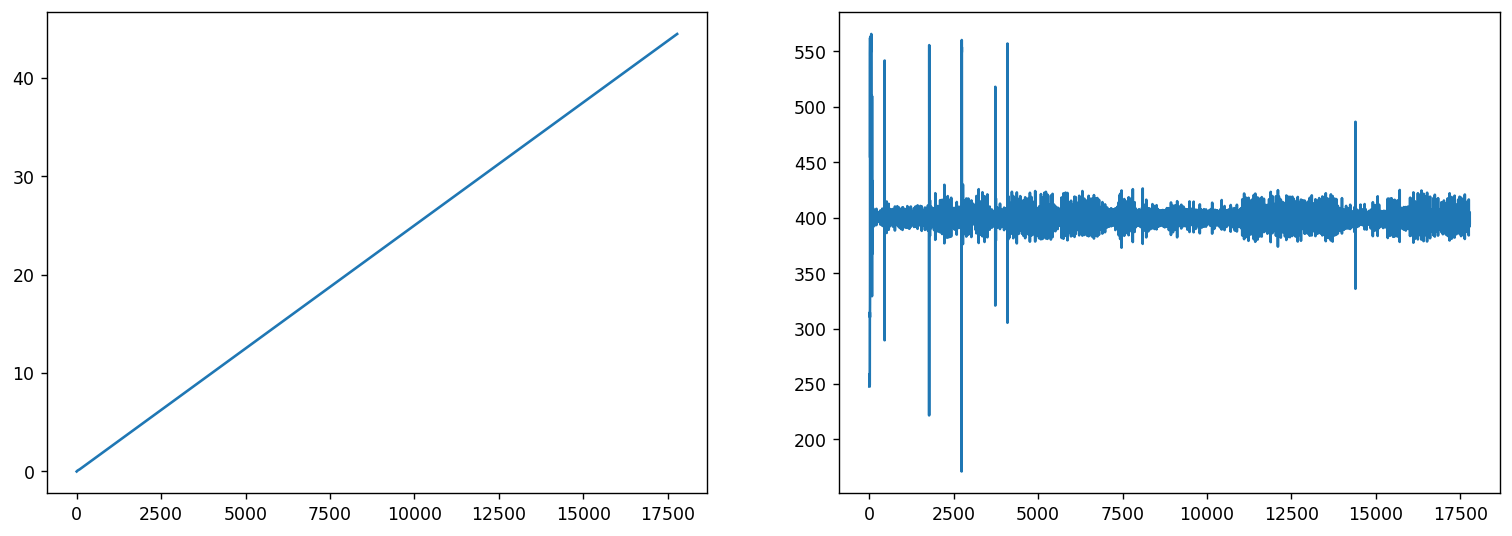

In [13]:

fun_times -= fun_times[0]
del_fun_times = fun_times[1:] - fun_times[:-1]
freqs = 1/del_fun_times
fig, axs = plt.subplots(nrows=1, ncols=2, dpi=125, figsize=(15,5))
axs[0].plot(fun_times)
axs[1].plot(freqs)
np.mean(del_fun_times), 1/np.mean(del_fun_times)

In [21]:
def zero_dm_channels():
    DM_STREAM0.write(np.zeros(DM_STREAM0.shape))
    DM_STREAM1.write(np.zeros(DM_STREAM0.shape))
    DM_STREAM2.write(np.zeros(DM_STREAM0.shape))
    DM_STREAM3.write(np.zeros(DM_STREAM0.shape))
    # DM_STREAM0.write(np.zeros(DM_STREAM0.shape))
    # DM_STREAM0.write(np.zeros(DM_STREAM0.shape))
    # DM_STREAM0.write(np.zeros(DM_STREAM0.shape))
    # DM_STREAM0.write(np.zeros(DM_STREAM0.shape))

zero_dm_channels()